## Import libraries and user-defined functions

In [1]:
import gc
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

from src.models.linear_models.pca_regressor import pca_regressor
from src.loaders.data_loader import load_energy_efficiency_dataset
from src.transformers.data_transformer import transform_energy_efficiency_dataset
from src.models.linear_models.elasticnet_pca_regressor import elasticnet_pca_regressor
from src.models.non_linear_models.decision_tree_regressor import decisiontree_regressor


## Import dataset

In [2]:
features_df, targets_df = load_energy_efficiency_dataset()


In [3]:
features_df.sample(n=3, random_state=123)


,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution
236,0.62,808.5,367.5,220.5,3.5,2.0,0.10,4.0
395,0.86,588.0,294.0,147.0,7.0,5.0,0.25,3.0
36,0.66,759.5,318.5,220.5,3.5,2.0,0.00,0.0


In [4]:
targets_df.sample(n=3, random_state=123)


,Heating_Load,Cooling_Load
236,12.85,14.37
395,29.07,29.82
36,7.18,12.40


## Data analysis - Part 1

In [5]:
features_df.describe().T


,count,mean,std,min,25%,50%,75%,max
Relative_Compactness,768.0,0.764167,0.105777,0.62,0.6825,0.75,0.830,0.98
Surface_Area,768.0,671.708333,88.086116,514.50,606.3750,673.75,741.125,808.50
Wall_Area,768.0,318.500000,43.626481,245.00,294.0000,318.50,343.000,416.50
Roof_Area,768.0,176.604167,45.165950,110.25,140.8750,183.75,220.500,220.50
Overall_Height,768.0,5.250000,1.751140,3.50,3.5000,5.25,7.000,7.00
Orientation,768.0,3.500000,1.118763,2.00,2.7500,3.50,4.250,5.00
Glazing_Area,768.0,0.234375,0.133221,0.00,0.1000,0.25,0.400,0.40
Glazing_Area_Distribution,768.0,2.812500,1.550960,0.00,1.7500,3.00,4.000,5.00


In [6]:
for feature in features_df.columns:
    print(f"Feature: {feature}, Number of unique values: {features_df[feature].nunique()}")


Feature: Relative_Compactness, Number of unique values: 12
Feature: Surface_Area, Number of unique values: 12
Feature: Wall_Area, Number of unique values: 7
Feature: Roof_Area, Number of unique values: 4
Feature: Overall_Height, Number of unique values: 2
Feature: Orientation, Number of unique values: 4
Feature: Glazing_Area, Number of unique values: 4
Feature: Glazing_Area_Distribution, Number of unique values: 6


- Each feature's mean is quite close to its corresponding median, and no extremely low/high values seem to be present.
- A further investigation shows that all features have few unique values; so converting them into categorical variables might be more beneficial.

In [7]:
targets_df.describe().T


,count,mean,std,min,25%,50%,75%,max
Heating_Load,768.0,22.307201,10.090196,6.01,12.9925,18.95,31.6675,43.10
Cooling_Load,768.0,24.587760,9.513306,10.90,15.6200,22.08,33.1325,48.03


In [8]:
for target in targets_df.columns:
    print(f"Target: {target}, Number of unique values: {targets_df[target].nunique()}")


Target: Heating_Load, Number of unique values: 586
Target: Cooling_Load, Number of unique values: 636


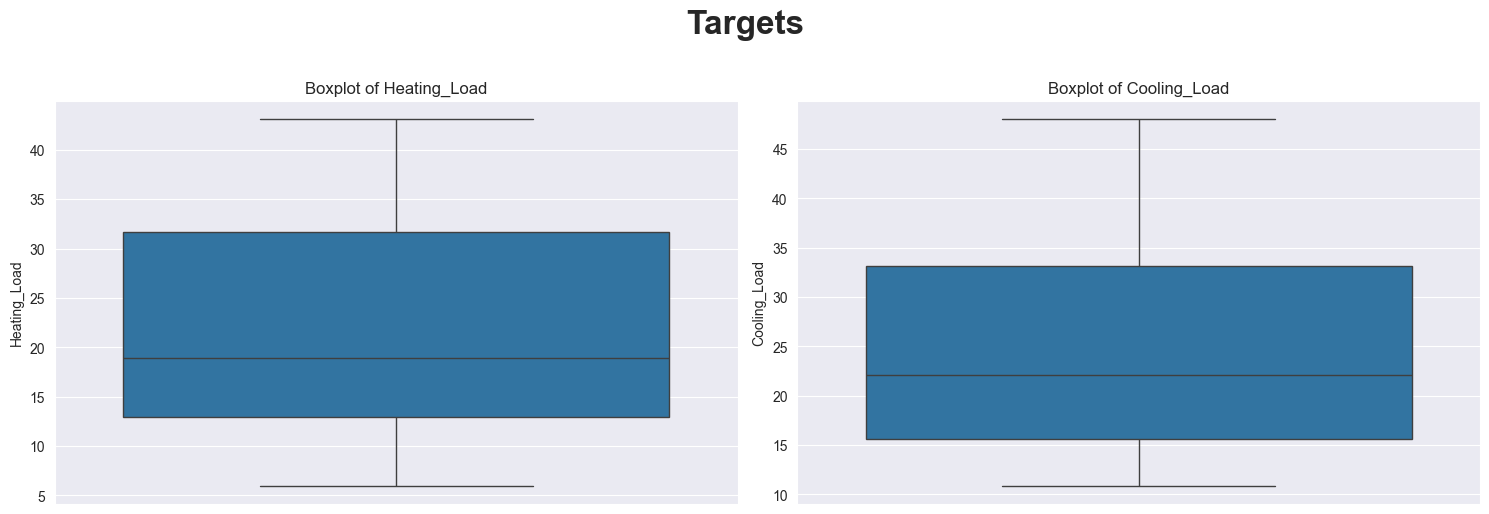

In [9]:
n_targets = len(targets_df.columns)
n_rows = (n_targets + 1) // 2
n_cols = 2

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(15, 5 * n_rows),
)
fig.tight_layout(pad=3.0)

fig.suptitle(
    "Targets",
    fontsize=24,
    fontweight='bold',
    y=1.02,
)

axes = np.array(axes).reshape(n_rows, n_cols)

for x, target in enumerate(targets_df.columns):
    row = x // 2
    col = x % 2

    sns.boxplot(
        data=targets_df,
        y=target,
        ax=axes[row, col],
    )
    axes[row, col].set_title(f"Boxplot of {target}")
    axes[row, col].set_ylabel(target)
    axes[row, col].set_xlabel("")

if n_targets % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()


Targets' boxplot don't show any sign of significant outliers.

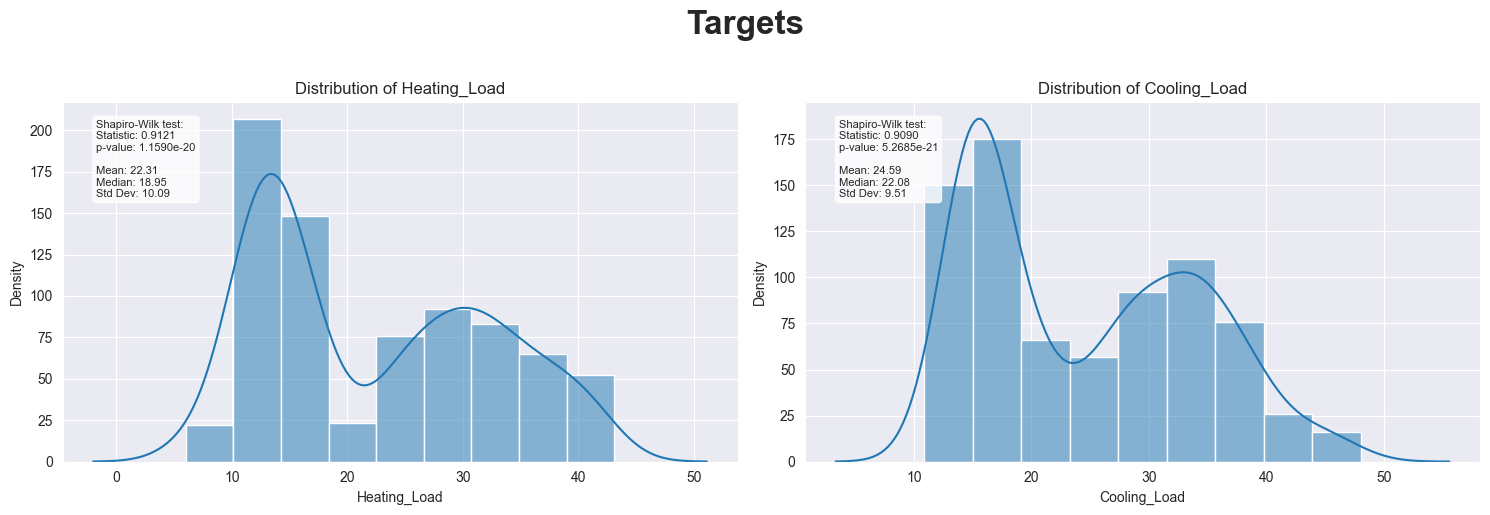

In [10]:
n_targets = len(targets_df.columns)
n_rows = (n_targets + 1) // 2
n_cols = 2

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(15, 5 * n_rows),
)
fig.tight_layout(pad=3.0)

fig.suptitle(
    "Targets",
    fontsize=24,
    fontweight='bold',
    y=1.02,
)

axes = np.array(axes).reshape(n_rows, n_cols)

for x, target in enumerate(targets_df.columns):

    row = x // 2
    col = x % 2

    target_data = targets_df[target]
    iqr = stats.iqr(target_data)
    bin_width = 2 * iqr / (len(target_data) ** (1/3))
    n_bins = int((target_data.max() - target_data.min()) / bin_width)

    sns.histplot(
        data=targets_df,
        x=target,
        kde=True,
        ax=axes[row, col],
        bins=n_bins,
        kde_kws={'cut': 3}
    )

    statistic, p_value = stats.shapiro(target_data)

    axes[row, col].set_title(f"Distribution of {target}")
    axes[row, col].set_xlabel(target)
    axes[row, col].set_ylabel("Density")

    mean = target_data.mean()
    median = target_data.median()
    std = target_data.std()

    stats_text = (f"Shapiro-Wilk test:\n"
                  f"Statistic: {statistic:.4f}\n"
                  f"p-value: {p_value:.4e}\n\n"
                  f"Mean: {mean:.2f}\n"
                  f"Median: {median:.2f}\n"
                  f"Std Dev: {std:.2f}")

    axes[row, col].text(
        0.05, 0.95,
        stats_text,
        transform=axes[row, col].transAxes, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
        fontsize=8
    )

if n_targets % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()


All targets' distributions don't statistically conform to a gaussian distribution.


## Feature engineering

In [11]:
data = transform_energy_efficiency_dataset(
    features_df=features_df,
    targets_df=targets_df,
)
gc.collect()


171

## Data analysis - Part 2

### _Noisy features_

- White gaussian noises were added to original features in the training set to create noisy ones.
- Purposes of these noisy features are to have a wider range of values for any of these original features, then eventually prevent any overfitting during training.
- Refer to <code>src/transformers/data_transformer.py</code> for all details on their creation.

In [12]:
data["train"]["features"]["noise"].describe().T


,count,mean,std,min,25%,50%,75%,max
Relative_Compactness,537.0,-8.269818e-17,1.000932,-2.847157,-0.699746,-0.047678,0.652248,3.324457
Surface_Area,537.0,8.600610e-16,1.000932,-1.735303,-0.896794,-0.077472,0.748309,1.572917
Wall_Area,537.0,1.653964e-16,1.000932,-1.725351,-0.589413,-0.031232,0.527496,2.217355
Roof_Area,537.0,-3.026753e-16,1.000932,-1.444038,-1.134411,-0.593613,1.016447,1.045861
Overall_Height,537.0,1.223933e-16,1.000932,-1.762849,-1.000117,0.471136,0.947181,1.654638
Orientation,537.0,3.969512e-16,1.000932,-2.148336,-0.846794,0.016944,0.819505,2.166695
Glazing_Area,537.0,3.307927e-18,1.000932,-3.574157,-0.662404,0.076782,0.705888,2.689023
Glazing_Area_Distribution,537.0,6.615854e-18,1.000932,-2.196026,-0.837834,0.017236,0.835181,1.952333


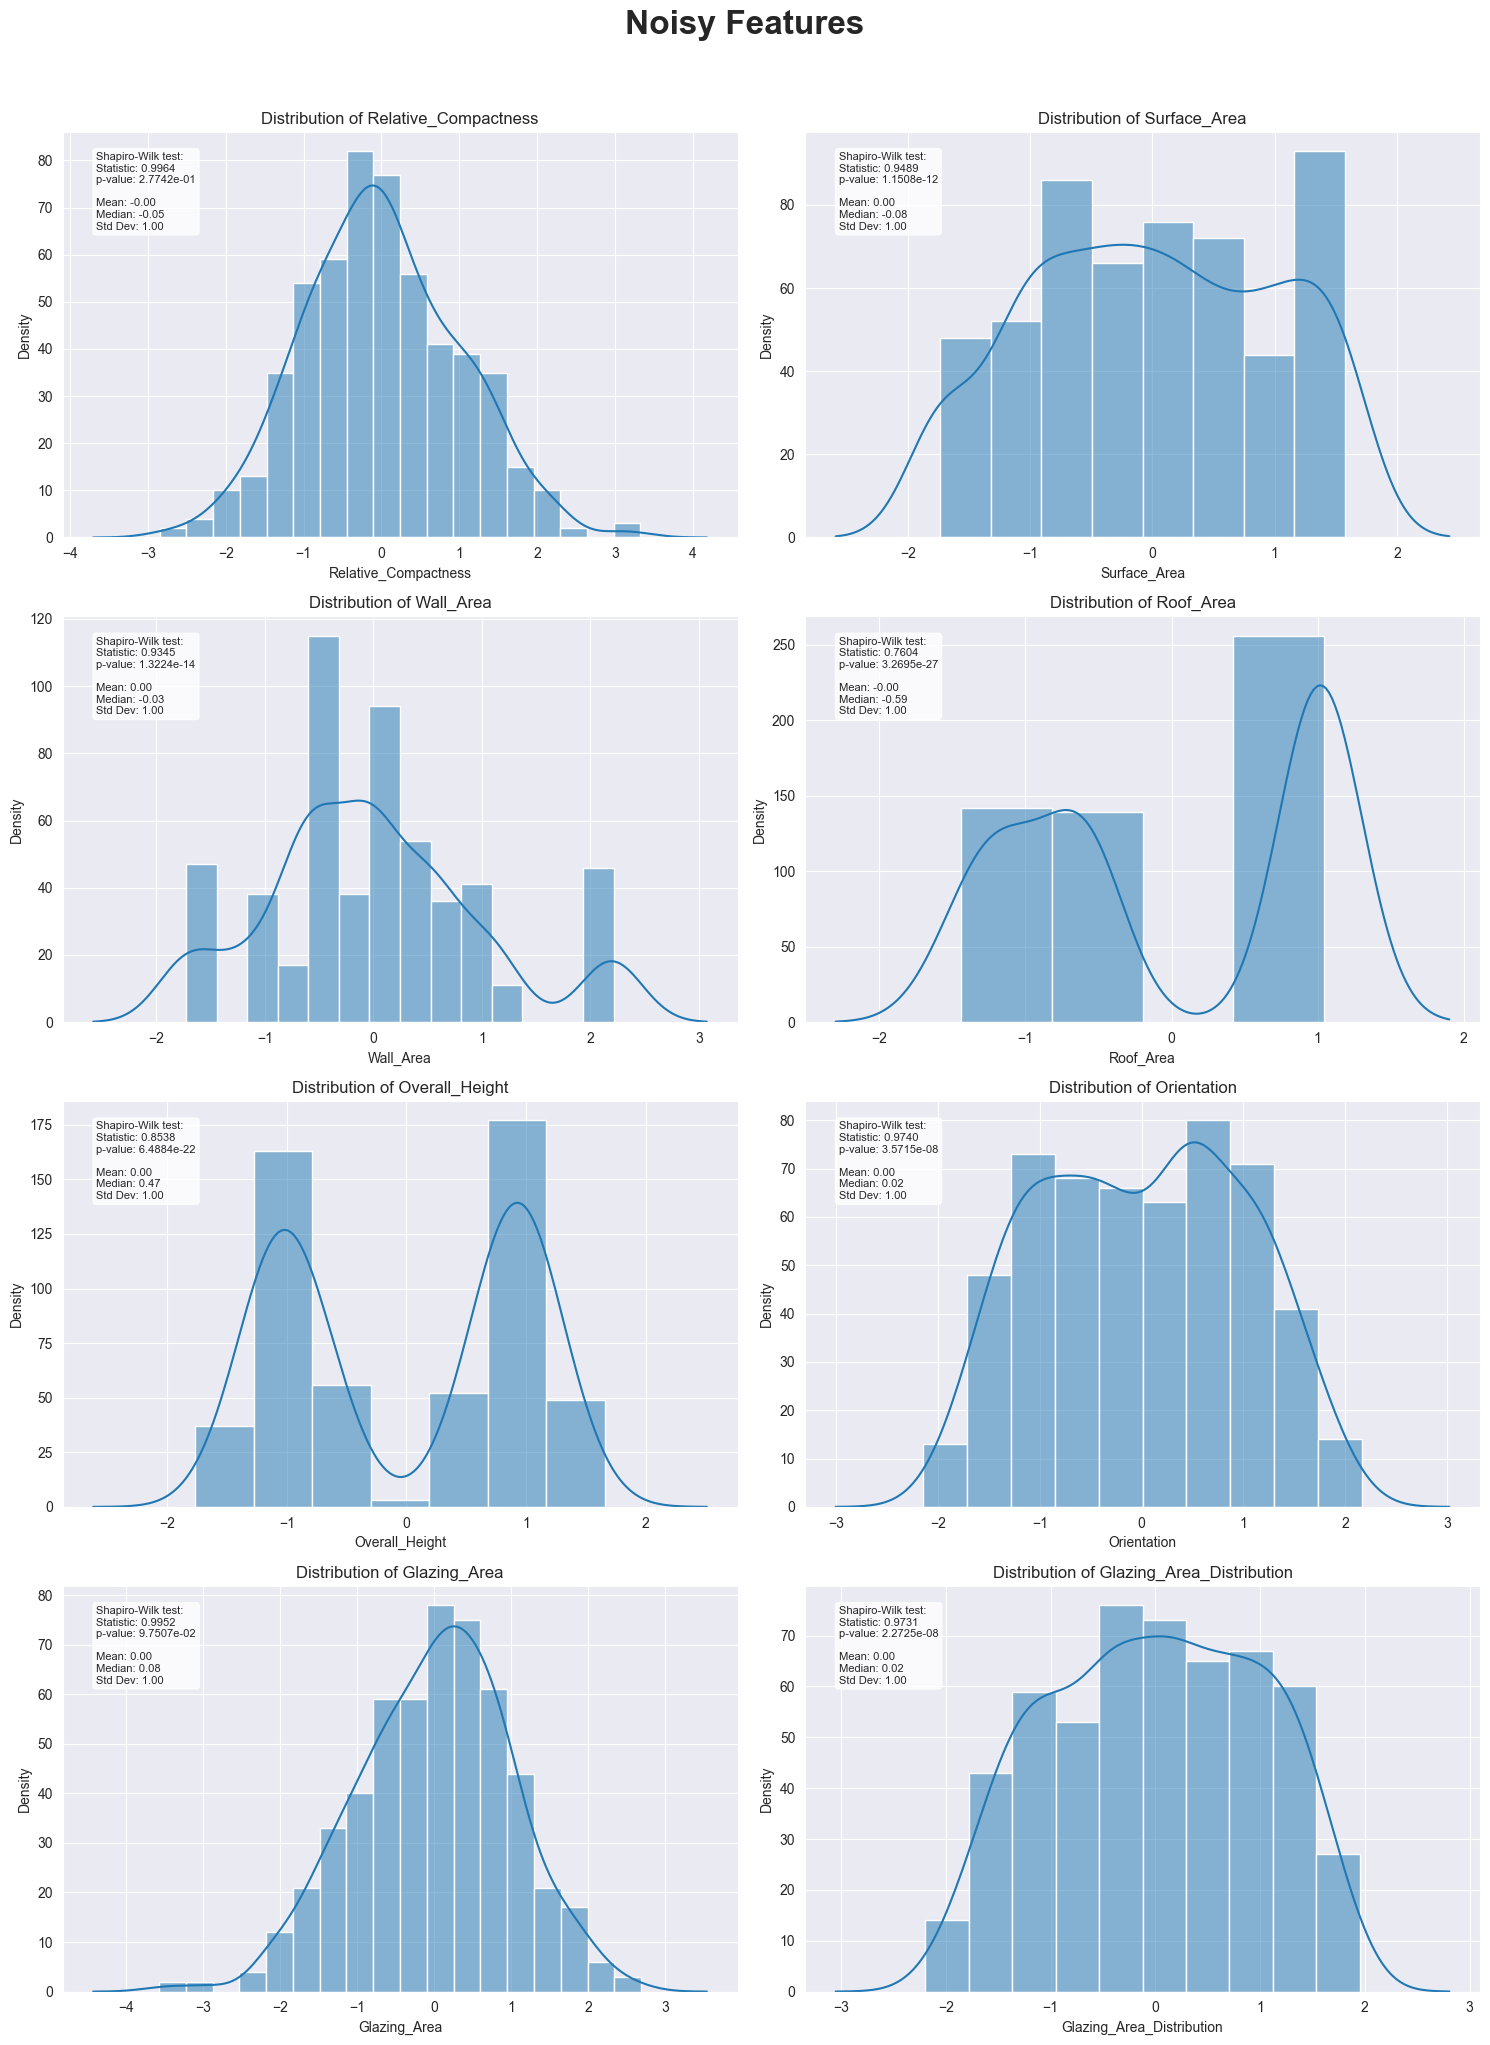

In [13]:
n_features = len(data["train"]["features"]["noise"].columns)
n_rows = (n_features + 1) // 2
n_cols = 2

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(15, 5 * n_rows),
)
fig.tight_layout(pad=3.0)

fig.suptitle(
    "Noisy Features",
    fontsize=24,
    fontweight='bold',
    y=1.02,
)

axes = np.array(axes).reshape(n_rows, n_cols)

for x, feature in enumerate(data["train"]["features"]["noise"].columns):

    row = x // 2
    col = x % 2

    feature_noisy_data = data["train"]["features"]["noise"][feature]
    iqr = stats.iqr(feature_noisy_data)
    bin_width = 2 * iqr / (len(feature_noisy_data) ** (1/3))
    n_bins = int((feature_noisy_data.max() - feature_noisy_data.min()) / bin_width)

    sns.histplot(
        data=data["train"]["features"]["noise"],
        x=feature,
        kde=True,
        ax=axes[row, col],
        bins=n_bins,
        kde_kws={'cut': 3}
    )

    statistic, p_value = stats.shapiro(feature_noisy_data)

    axes[row, col].set_title(f"Distribution of {feature}")
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel("Density")

    mean = feature_noisy_data.mean()
    median = feature_noisy_data.median()
    std = feature_noisy_data.std()

    stats_text = (f"Shapiro-Wilk test:\n"
                  f"Statistic: {statistic:.4f}\n"
                  f"p-value: {p_value:.4e}\n\n"
                  f"Mean: {mean:.2f}\n"
                  f"Median: {median:.2f}\n"
                  f"Std Dev: {std:.2f}")

    axes[row, col].text(
        0.05, 0.95,
        stats_text,
        transform=axes[row, col].transAxes, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
        fontsize=8
    )

if n_targets % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()


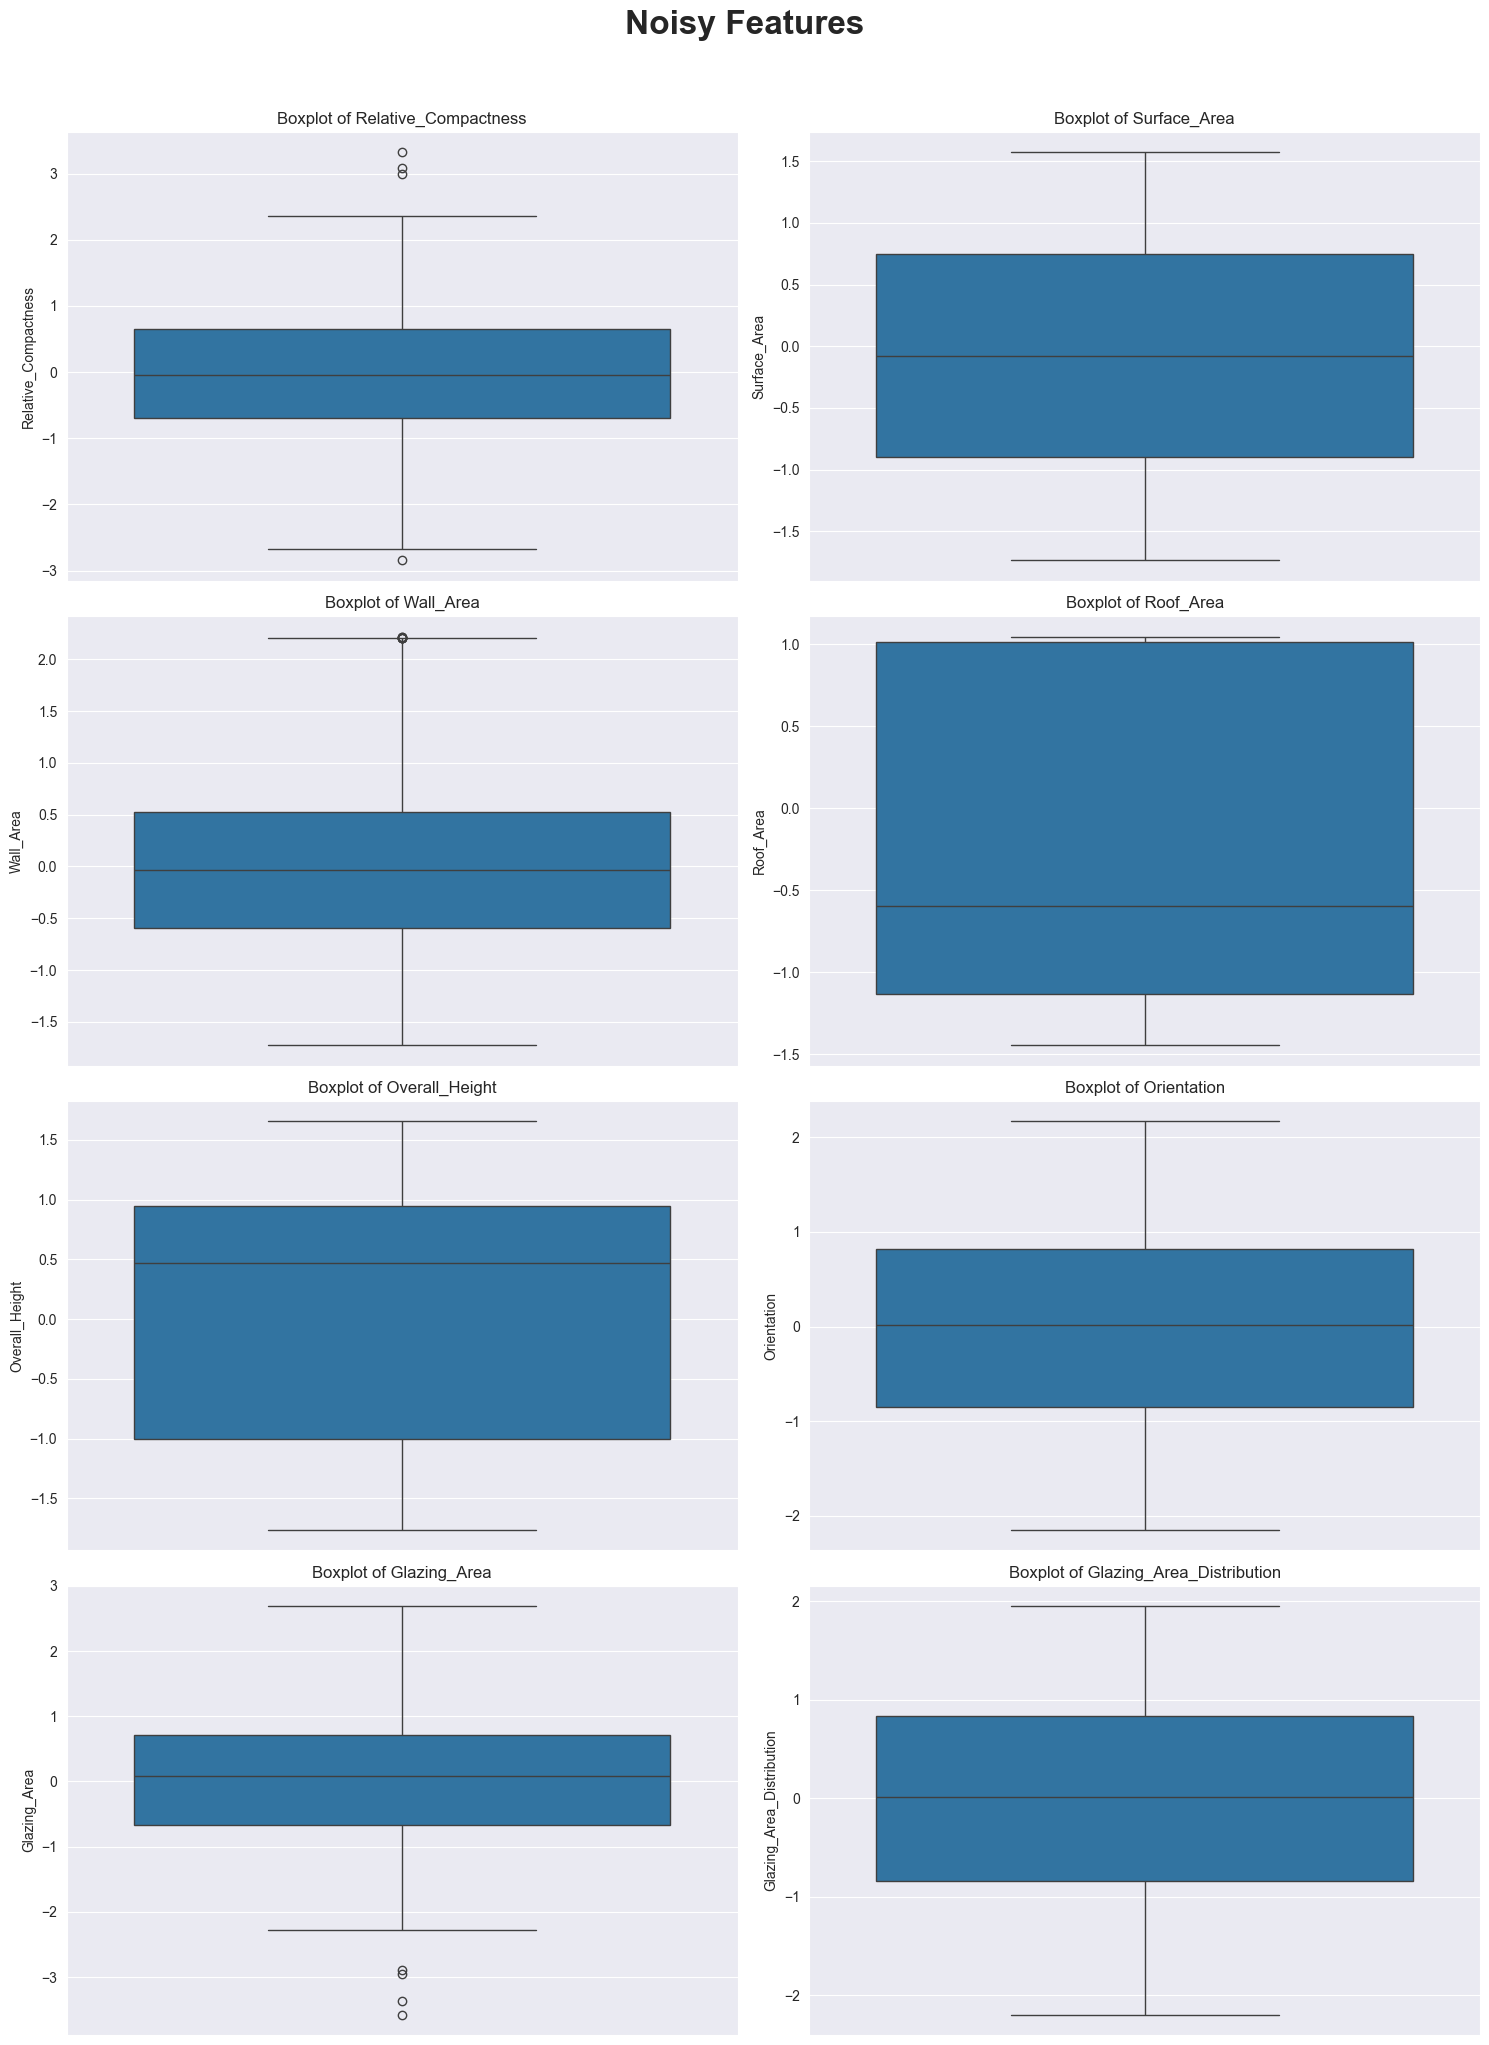

In [14]:
n_features = len(data["train"]["features"]["noise"].columns)
n_rows = (n_features + 1) // 2
n_cols = 2

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(15, 5 * n_rows),
)
fig.tight_layout(pad=3.0)

fig.suptitle(
    "Noisy Features",
    fontsize=24,
    fontweight='bold',
    y=1.02,
)

axes = np.array(axes).reshape(n_rows, n_cols)

for x, feature in enumerate(data["train"]["features"]["noise"].columns):

    row = x // 2
    col = x % 2

    sns.boxplot(
        data=data["train"]["features"]["noise"],
        y=feature,
        ax=axes[row, col],
    )
    axes[row, col].set_title(f"Boxplot of {feature}")
    axes[row, col].set_ylabel(feature)
    axes[row, col].set_xlabel("")

if n_features % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()


In [15]:
for feature in data["train"]["features"]["noise"].columns:
    print(f"Feature: {feature}, Number of unique values: {data["train"]["features"]["noise"][feature].nunique()}")


Feature: Relative_Compactness, Number of unique values: 537
Feature: Surface_Area, Number of unique values: 537
Feature: Wall_Area, Number of unique values: 537
Feature: Roof_Area, Number of unique values: 537
Feature: Overall_Height, Number of unique values: 537
Feature: Orientation, Number of unique values: 537
Feature: Glazing_Area, Number of unique values: 537
Feature: Glazing_Area_Distribution, Number of unique values: 537


- The introduction of white gaussian noises has made original features more continuous than their original versions.
- Their boxplot don't seem to show any significant outlier to be concerned about.

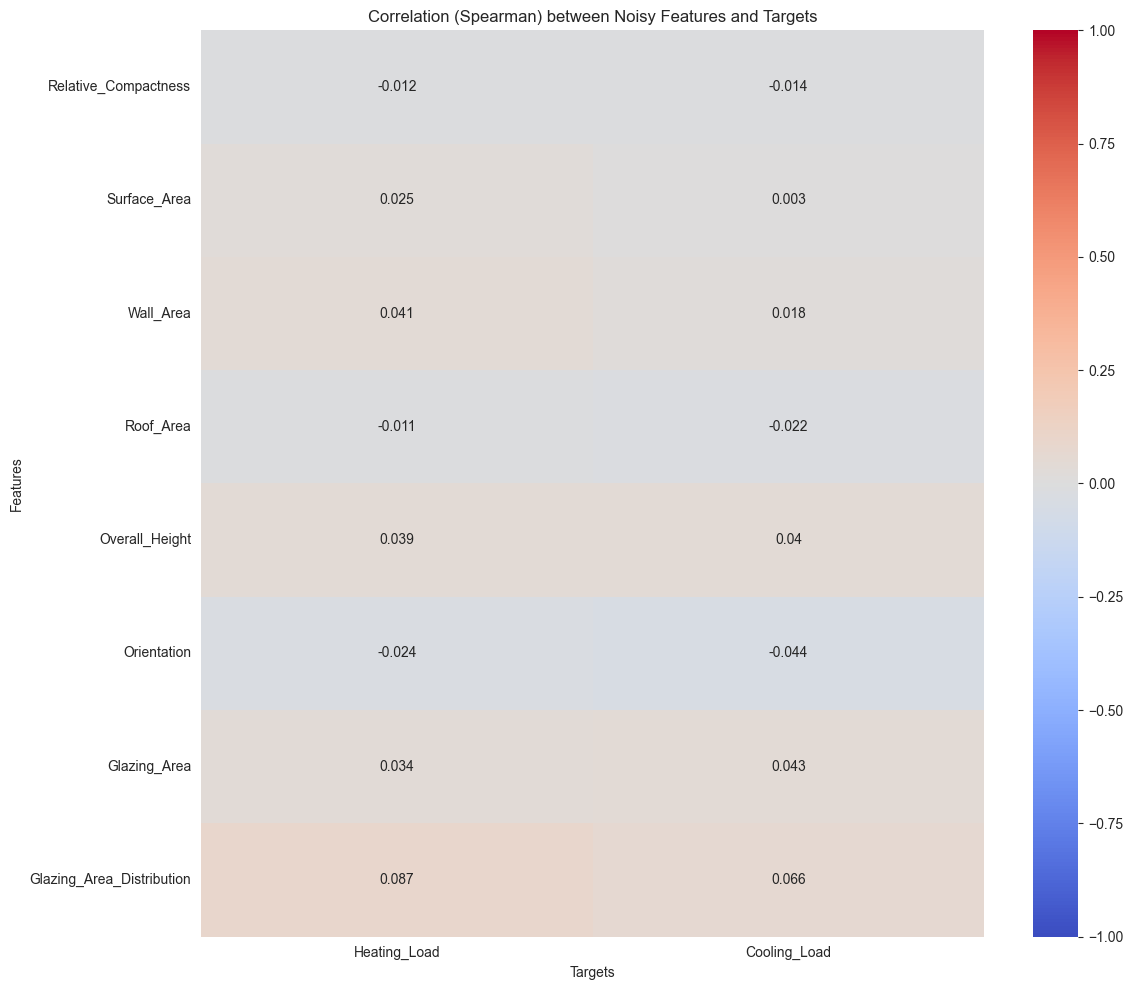

In [16]:
correlation_matrix = pd.DataFrame(index=data["train"]["features"]["noise"].columns, columns=data["train"]["targets"].columns)
for feature in data["train"]["features"]["noise"].columns:
    for target in data["train"]["targets"].columns:
        correlation_matrix.loc[feature, target] = data["train"]["features"]["noise"][feature].corr(data["train"]["targets"][target], method="spearman")
correlation_matrix = correlation_matrix.astype(float)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.title("Correlation (Spearman) between Noisy Features and Targets")
plt.xlabel("Targets")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


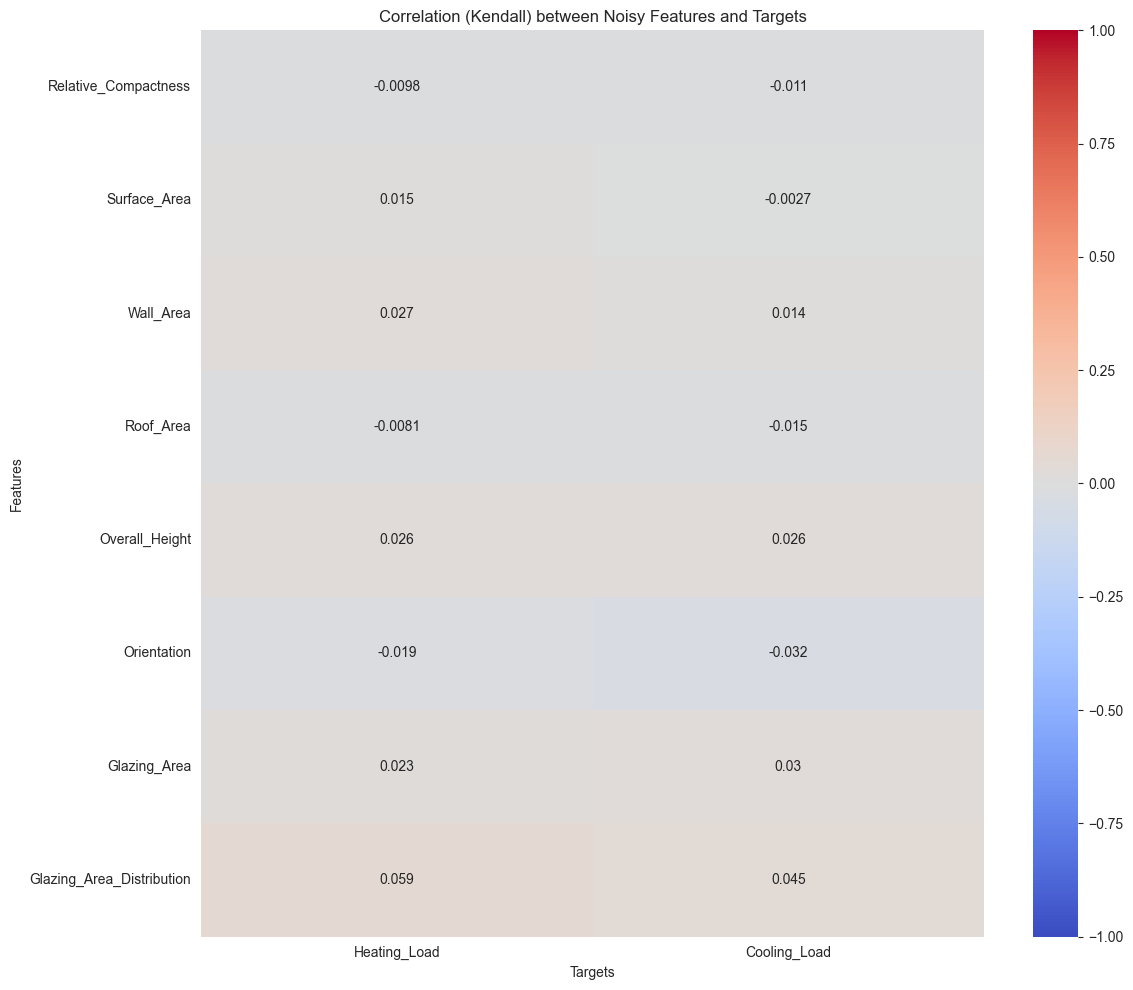

In [17]:
correlation_matrix = pd.DataFrame(index=data["train"]["features"]["noise"].columns, columns=data["train"]["targets"].columns)
for feature in data["train"]["features"]["noise"].columns:
    for target in data["train"]["targets"].columns:
        correlation_matrix.loc[feature, target] = data["train"]["features"]["noise"][feature].corr(data["train"]["targets"][target], method="kendall")
correlation_matrix = correlation_matrix.astype(float)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.title("Correlation (Kendall) between Noisy Features and Targets")
plt.xlabel("Targets")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


- Spearman correlation found between features and targets vary from -9.9% to 5.3%; whereas Kendall shows values from -6.7% to 3.4%.
- Linear correlations between these noisy features and targets aren't quite strong.

In [18]:
data["train"]["features"]["noise"].corr(method="spearman")


,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution
Relative_Compactness,1.000000,-0.199222,-0.000882,-0.211366,0.180579,0.001313,-0.013377,-0.027491
Surface_Area,-0.199222,1.000000,0.286912,0.818480,-0.735905,0.030831,-0.028840,0.012987
Wall_Area,-0.000882,0.286912,1.000000,-0.104965,0.163644,0.035300,-0.036658,0.003061
Roof_Area,-0.211366,0.818480,-0.104965,1.000000,-0.738000,-0.000883,0.009291,0.024704
Overall_Height,0.180579,-0.735905,0.163644,-0.738000,1.000000,-0.034436,0.051975,-0.068113
Orientation,0.001313,0.030831,0.035300,-0.000883,-0.034436,1.000000,0.003319,-0.003282
Glazing_Area,-0.013377,-0.028840,-0.036658,0.009291,0.051975,0.003319,1.000000,0.110976
Glazing_Area_Distribution,-0.027491,0.012987,0.003061,0.024704,-0.068113,-0.003282,0.110976,1.000000


In [19]:
data["train"]["features"]["noise"].corr(method="kendall")


,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution
Relative_Compactness,1.000000,-0.132619,-0.001404,-0.142264,0.122433,0.000889,-0.009325,-0.018983
Surface_Area,-0.132619,1.000000,0.259290,0.593179,-0.483629,0.021026,-0.019817,0.008574
Wall_Area,-0.001404,0.259290,1.000000,-0.062036,0.112079,0.023000,-0.022458,0.001987
Roof_Area,-0.142264,0.593179,-0.062036,1.000000,-0.486992,-0.001070,0.007616,0.015718
Overall_Height,0.122433,-0.483629,0.112079,-0.486992,1.000000,-0.022235,0.033589,-0.046388
Orientation,0.000889,0.021026,0.023000,-0.001070,-0.022235,1.000000,0.002821,-0.001946
Glazing_Area,-0.009325,-0.019817,-0.022458,0.007616,0.033589,0.002821,1.000000,0.073585
Glazing_Area_Distribution,-0.018983,0.008574,0.001987,0.015718,-0.046388,-0.001946,0.073585,1.000000


- Both Kendall and Spearman show high correlation between features such as Surface_Area, Roof_Area, and Overall_Height.
- Having them less correlated through a Principal Component Analysis (PCA) would be beneficial before their usage in any regression model.


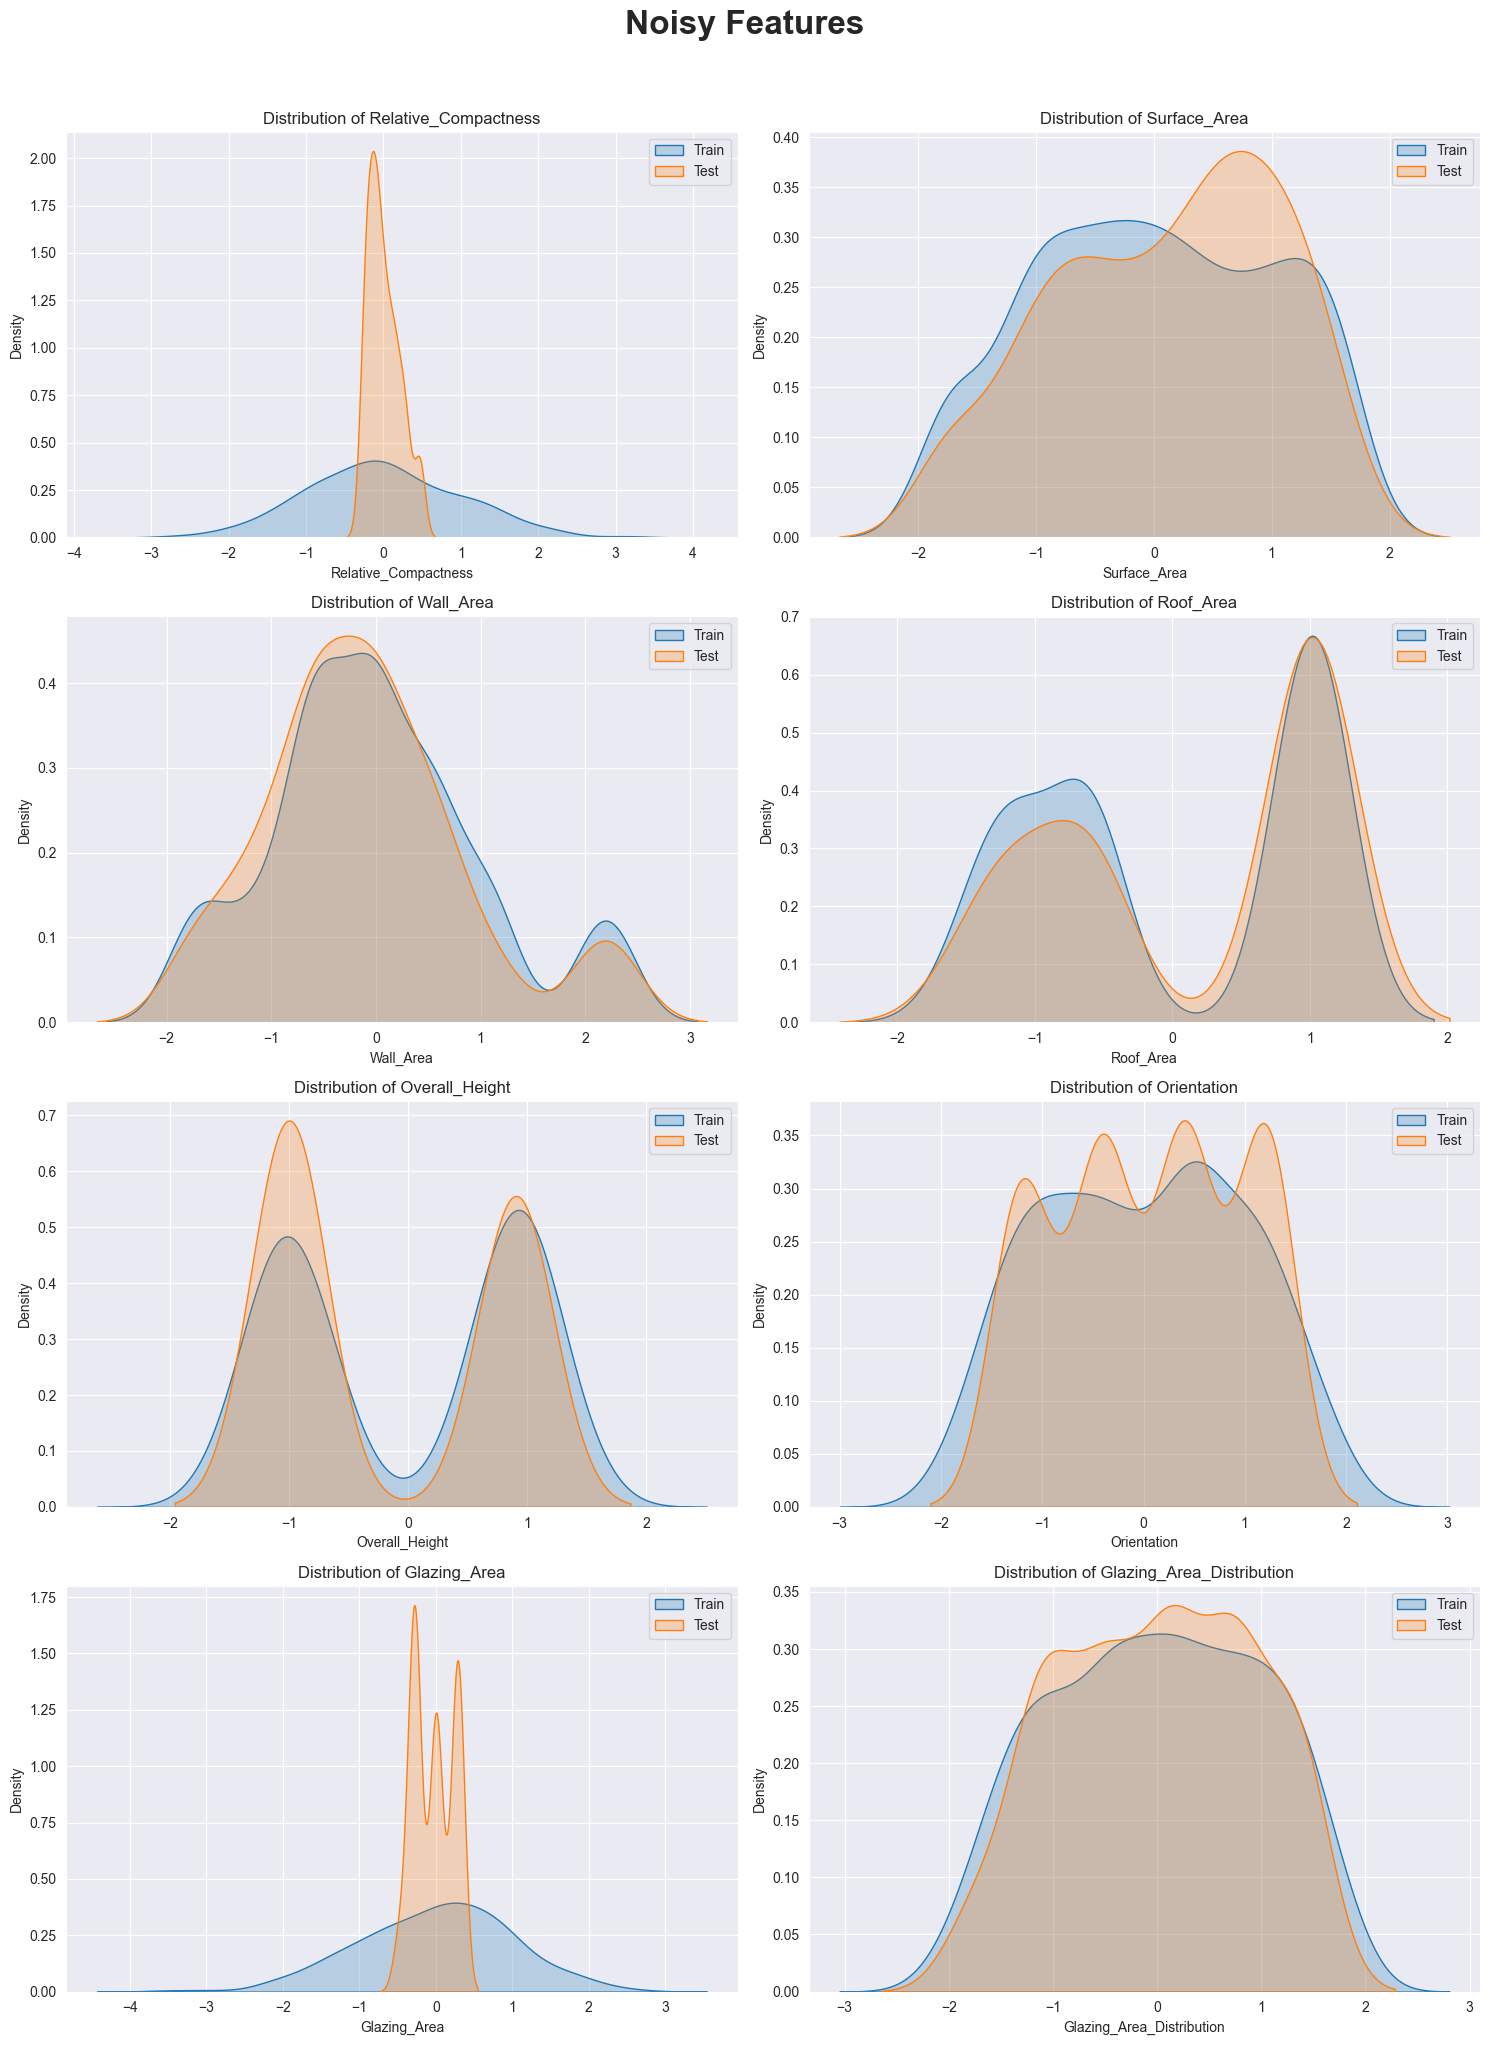

In [20]:
n_features = len(data["train"]["features"]["noise"].columns)
n_rows = (n_features + 1) // 2
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
fig.tight_layout(pad=3.0)

fig.suptitle(
    "Noisy Features",
    fontsize=24,
    fontweight='bold',
    y=1.02,
)

for x, feature in enumerate(data["train"]["features"]["noise"].columns):
    row = x // 2
    col = x % 2

    ax = axes[row, col] if n_rows > 1 else axes[col]

    sns.kdeplot(
        data=data["train"]["features"]["noise"][feature],
        label="Train",
        fill=True,
        ax=ax,
    )
    sns.kdeplot(
        data=data["test"]["features"]["noise"][feature],
        label="Test",
        fill=True,
        ax=ax,
    )

    ax.set_title(f"Distribution of {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Density")
    ax.legend()

if n_features % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()


In [21]:
for feature in data["train"]["features"]["noise"].columns:
    print("--------------------------------------------------")
    statistic, p_value = stats.ks_2samp(data["train"]["features"]["noise"][feature], data["test"]["features"]["noise"][feature])
    print(f"Feature: {feature}, Kolmogorov-Smirnov statistic: {statistic:.3f}, p-value: {p_value:.3f}")
    print("--------------------------------------------------")


--------------------------------------------------
Feature: Relative_Compactness, Kolmogorov-Smirnov statistic: 0.400, p-value: 0.000
--------------------------------------------------
--------------------------------------------------
Feature: Surface_Area, Kolmogorov-Smirnov statistic: 0.130, p-value: 0.007
--------------------------------------------------
--------------------------------------------------
Feature: Wall_Area, Kolmogorov-Smirnov statistic: 0.195, p-value: 0.000
--------------------------------------------------
--------------------------------------------------
Feature: Roof_Area, Kolmogorov-Smirnov statistic: 0.333, p-value: 0.000
--------------------------------------------------
--------------------------------------------------
Feature: Overall_Height, Kolmogorov-Smirnov statistic: 0.308, p-value: 0.000
--------------------------------------------------
--------------------------------------------------
Feature: Orientation, Kolmogorov-Smirnov statistic: 0.160, p

According to the Kolmogorov-Smirnov test of a 95% confidence level, there is significant difference between the distributions of the noisy features in the training and test sets.

In [22]:
del correlation_matrix
gc.collect()


53145

### _Targets_

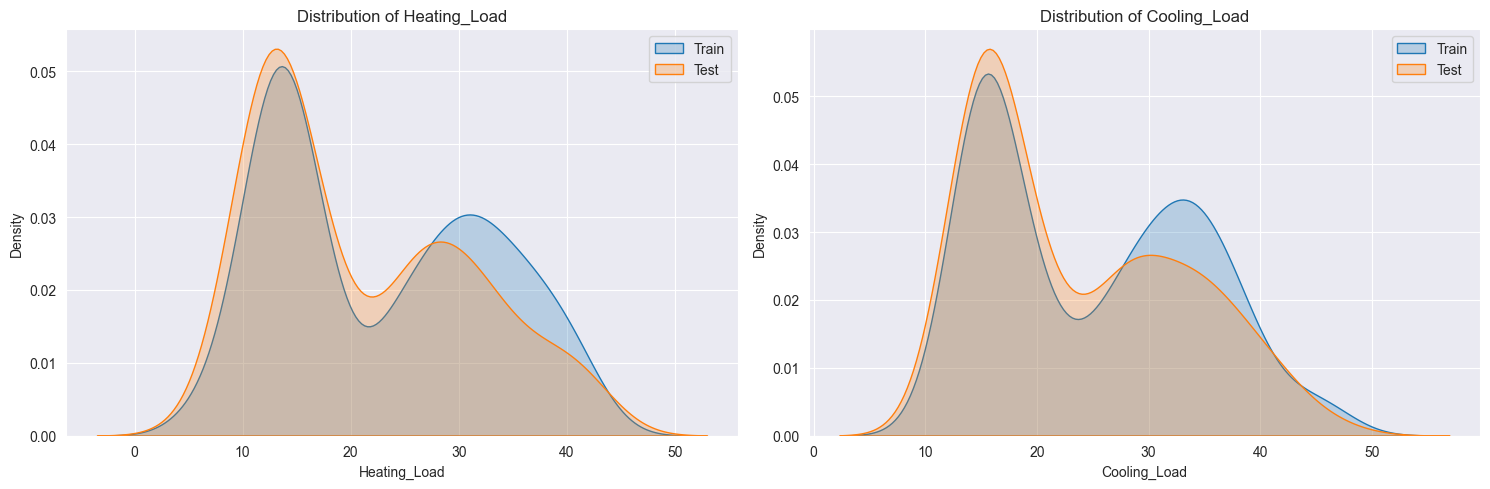

In [23]:
n_targets = len(data["train"]["targets"].columns)
n_rows = (n_targets + 1) // 2
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
fig.tight_layout(pad=3.0)

for x, target in enumerate(data["train"]["targets"].columns):
    row = x // 2
    col = x % 2

    ax = axes[row, col] if n_rows > 1 else axes[col]

    sns.kdeplot(
        data=data["train"]["targets"][target],
        label="Train",
        fill=True,
        ax=ax,
    )
    sns.kdeplot(
        data=data["test"]["targets"][target],
        label="Test",
        fill=True,
        ax=ax,
    )
    ax.set_title(f"Distribution of {target}")
    ax.set_xlabel(target)
    ax.set_ylabel("Density")
    ax.legend()

if n_targets % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()


In [24]:
for target in data["train"]["targets"].columns:
    print("--------------------------------------------------")
    statistic, p_value = stats.ks_2samp(
        data1=data["train"]["targets"][target],
        data2=data["test"]["targets"][target],
    )
    print(f"Target: {target}, Kolmogorov-Smirnov statistic: {statistic:.3f}, p-value: {p_value:.3f}")
    print("--------------------------------------------------")


--------------------------------------------------
Target: Heating_Load, Kolmogorov-Smirnov statistic: 0.115, p-value: 0.026
--------------------------------------------------
--------------------------------------------------
Target: Cooling_Load, Kolmogorov-Smirnov statistic: 0.105, p-value: 0.053
--------------------------------------------------


According to the Kolmogorov-Smirnov test of a 95% confidence level, it's not possible to statistically affirm that the target Heating_Load have similar data distribution in the training and test sets.

## Launch MLflow server to record some experiments

We will run some MLflow experiments locally. Before going any further from the section `pca + linear regression + elasticnet`, don't forget to start your local server with commands such as :

`mlflow server --host localhost --port 9999`.

You can change the server uri and port according to your setup.

In [25]:
mlflow.set_tracking_uri("http://localhost:9999")

## Linear models

### pca + linear regression

In [26]:
training_pca_results = {
    "original": pca_regressor(
        features_df=data["train"]["features"]["original"],
        targets_df=data["train"]["targets"],
        operation_mode="train",
    ),
    "noise": pca_regressor(
        features_df=data["train"]["features"]["noise"],
        targets_df=data["train"]["targets"],
        operation_mode="train",
    ),
}


In [27]:
test_pca_results = {
    "original": pca_regressor(
        features_df=data["test"]["features"]["original"],
        targets_df=data["test"]["targets"],
        operation_mode="test",
        prediction_models=training_pca_results["original"],
    ),
    "noise": pca_regressor(
        features_df=data["test"]["features"]["noise"],
        targets_df=data["test"]["targets"],
        operation_mode="test",
        prediction_models=training_pca_results["noise"],
    ),
}


In [28]:
pca_perfs = []

for target_name in data["train"]["targets"].columns:
    for version in ["original", "noise"]:
        pca_perfs.append(
            {
                "Target": target_name,
                "Features version": version,
                "Train MSE": f"{training_pca_results[version][target_name]['train_mse_score']:.3f}",
                "Train R2": f"{training_pca_results[version][target_name]['train_r2_score']:.3f}",
                "Validation MSE": f"{training_pca_results[version][target_name]['val_mse_score']:.3f}",
                "Validation R2": f"{training_pca_results[version][target_name]['val_r2_score']:.3f}",
                "Test MSE": f"{test_pca_results[version][target_name]['mse_score']:.3f}",
                "Test R2": f"{test_pca_results[version][target_name]['r2_score']:.3f}"
            }
        )

pca_perfs_df = pd.DataFrame(pca_perfs)
pca_perfs_df


,Target,Features version,Train MSE,Train R2,Validation MSE,Validation R2,Test MSE,Test R2
0,Heating_Load,original,15.360,0.851,15.861,0.845,45.219,0.526
1,Heating_Load,noise,19.503,0.811,20.034,0.805,22.469,0.764
2,Cooling_Load,original,16.915,0.816,17.385,0.809,35.118,0.589
3,Cooling_Load,noise,18.838,0.795,19.356,0.788,19.272,0.774


- Linear models using PCA components have shown high R-squared values (at least 0.7) during the training  and validation for both targets and any version of the features.
- Comparing training and validation results have shown that no model has been severely overfitted.
- Noisy versions of the features had the best generalization performance for both metrics (mse, r2) for all targets.

In [29]:
gc.collect()


27357

### pca + linear regression + elasticnet

In [30]:
training_pca_elasticnet_results = {
    "original": elasticnet_pca_regressor(
        features_df=data["train"]["features"]["original"],
        targets_df=data["train"]["targets"],
        operation_mode="train",
        experiment_name=f"/regularized_linear_pca_regression_for_energy_efficiency_prediction-original-{datetime.now().strftime('%Y-%m-%d')}"
    ),
    "noise": elasticnet_pca_regressor(
        features_df=data["train"]["features"]["noise"],
        targets_df=data["train"]["targets"],
        operation_mode="train",
        experiment_name=f"/regularized_linear_pca_regression_for_energy_efficiency_prediction-noise-{datetime.now().strftime('%Y-%m-%d')}"
    ),
}


Experiment /regularized_linear_pca_regression_for_energy_efficiency_prediction-original-2025-02-03 exists and is active.
🏃 View run silent-stag-127 at: http://localhost:9999/#/experiments/789873737317235565/runs/ed5e1c4314974beab0d8958cd60867c8

🧪 View experiment at: http://localhost:9999/#/experiments/789873737317235565

🏃 View run brawny-squid-501 at: http://localhost:9999/#/experiments/789873737317235565/runs/f04974d8453e40e9918fbd0d00a4942a

🧪 View experiment at: http://localhost:9999/#/experiments/789873737317235565 

🏃 View run likeable-mink-863 at: http://localhost:9999/#/experiments/789873737317235565/runs/6ec6a5657f314110a2b4ecf89ccec705

🧪 View experiment at: http://localhost:9999/#/experiments/789873737317235565 

🏃 View run rumbling-hawk-237 at: http://localhost:9999/#/experiments/789873737317235565/runs/83169e522f584e0b85ef6208ae822c78

🧪 View experiment at: http://localhost:9999/#/experiments/789873737317235565 

🏃 View run nosy-skunk-686 at: http://localhost:9999/#/exper

In [31]:
test_pca_elasticnet_results = {
    "original": elasticnet_pca_regressor(
        features_df=data["test"]["features"]["original"],
        targets_df=data["test"]["targets"],
        operation_mode="test",
        best_run=training_pca_elasticnet_results["original"],
    ),
    "noise": elasticnet_pca_regressor(
        features_df=data["test"]["features"]["noise"],
        targets_df=data["test"]["targets"],
        operation_mode="test",
        best_run=training_pca_elasticnet_results["noise"],
    ),
}


In [32]:
elasticnet_pca_perfs = []

for version in ["original", "noise"]:
    elasticnet_pca_perfs.append(
        {
            "Features version": version,
            "Train MSE": f"{training_pca_elasticnet_results[version]['train_mse_score']:.3f}",
            "Train R2": f"{training_pca_elasticnet_results[version]['train_r2_score']:.3f}",
            "Validation MSE": f"{training_pca_elasticnet_results[version]['val_mse_score']:.3f}",
            "Validation R2": f"{training_pca_elasticnet_results[version]['val_r2_score']:.3f}",
            "Test MSE": f"{test_pca_elasticnet_results[version]['mse_score']:.3f}",
            "Test R2": f"{test_pca_elasticnet_results[version]['r2_score']:.3f}",
        }
    )

elasticnet_pca_perfs_df = pd.DataFrame(elasticnet_pca_perfs)
elasticnet_pca_perfs_df


,Features version,Train MSE,Train R2,Validation MSE,Validation R2,Test MSE,Test R2
0,original,16.917,0.816,17.884,0.809,44.964,0.528
1,noise,19.588,0.795,21.057,0.786,22.399,0.765


- Regularized linear models using PCA components have shown high R-squared values (at least 0.7) during the training and validation for both targets and any version of the features.
- Comparing training and validation results have shown that no model has been severely overfitted.
- Noisy versions of the features had the best generalization performance for both metrics (mse, r2) for all targets.

In [33]:
gc.collect()


1017

## Non Linear models

### decision tree

In [34]:
training_decisiontree_results = {
    "original": decisiontree_regressor(
        features_df=data["train"]["features"]["original"],
        targets_df=data["train"]["targets"],
        operation_mode="train",
        experiment_name=f"/decision_tree_for_energy_efficiency_prediction-original-{datetime.now().strftime('%Y-%m-%d')}"
    ),
    "noise": decisiontree_regressor(
        features_df=data["train"]["features"]["noise"],
        targets_df=data["train"]["targets"],
        operation_mode="train",
        experiment_name=f"/decision_tree__for_energy_efficiency_prediction-noise-{datetime.now().strftime('%Y-%m-%d')}"
    ),
}

Experiment /decision_tree_for_energy_efficiency_prediction-original-2025-02-03 exists and is active.
🏃 View run kindly-crab-230 at: http://localhost:9999/#/experiments/127521691794418788/runs/efed08b9e86d4d5a989f786199b7fb18

🧪 View experiment at: http://localhost:9999/#/experiments/127521691794418788

🏃 View run stylish-kit-580 at: http://localhost:9999/#/experiments/127521691794418788/runs/4d028b5d4ca04967a90a7b40e1a362be

🧪 View experiment at: http://localhost:9999/#/experiments/127521691794418788  

🏃 View run illustrious-mare-974 at: http://localhost:9999/#/experiments/127521691794418788/runs/f5eebdd0c3a54eae8afe3515ab2be660

🧪 View experiment at: http://localhost:9999/#/experiments/127521691794418788  

🏃 View run unique-stoat-28 at: http://localhost:9999/#/experiments/127521691794418788/runs/49f7edf19f3a45f3b492a50efe7b0557

🧪 View experiment at: http://localhost:9999/#/experiments/127521691794418788  

🏃 View run whimsical-midge-197 at: http://localhost:9999/#/experiments/12752

In [35]:
test_decisiontree_results = {
    "original": decisiontree_regressor(
        features_df=data["test"]["features"]["original"],
        targets_df=data["test"]["targets"],
        operation_mode="test",
        best_run=training_decisiontree_results["original"],
    ),
    "noise": decisiontree_regressor(
        features_df=data["test"]["features"]["noise"],
        targets_df=data["test"]["targets"],
        operation_mode="test",
        best_run=training_decisiontree_results["noise"],
    ),
}


In [36]:
decisiontree_perfs = []

for version in ["original", "noise"]:
    decisiontree_perfs.append(
        {
            "Features version": version,
            "Train MSE": f"{training_decisiontree_results[version]['train_mse_score']:.3f}",
            "Train R2": f"{training_decisiontree_results[version]['train_r2_score']:.3f}",
            "Validation MSE": f"{training_decisiontree_results[version]['val_mse_score']:.3f}",
            "Validation R2": f"{training_decisiontree_results[version]['val_r2_score']:.3f}",
            "Test MSE": f"{test_decisiontree_results[version]['mse_score']:.3f}",
            "Test R2": f"{test_decisiontree_results[version]['r2_score']:.3f}",
        }
    )

decisiontree_perfs_df = pd.DataFrame(decisiontree_perfs)
decisiontree_perfs_df


,Features version,Train MSE,Train R2,Validation MSE,Validation R2,Test MSE,Test R2
0,original,2.761,0.970,3.886,0.958,3.171,0.963
1,noise,8.512,0.918,10.110,0.900,9.043,0.905


- Decision trees performance is significantly higher than linear models' one.
- Noisy features seem to be a good option in the linear case, but with decision trees, the noise seems to have a negative impact.

In [37]:
training_decisiontree_results["original"]["features_importance"]

,feature,importance
0,Relative_Compactness,0.009339
1,Surface_Area,0.087980
2,Wall_Area,0.014661
3,Roof_Area,0.000770
4,Overall_Height,0.808263
5,Orientation,0.000518
6,Glazing_Area,0.074460
7,Glazing_Area_Distribution,0.004009


- The feature Overall_Height appears to be the most important feature in predicting targets.
- His importance score is at least 10 times greater than this of any other feature.
- The decision tree will be the final model kept for the energy efficiency prediction task.

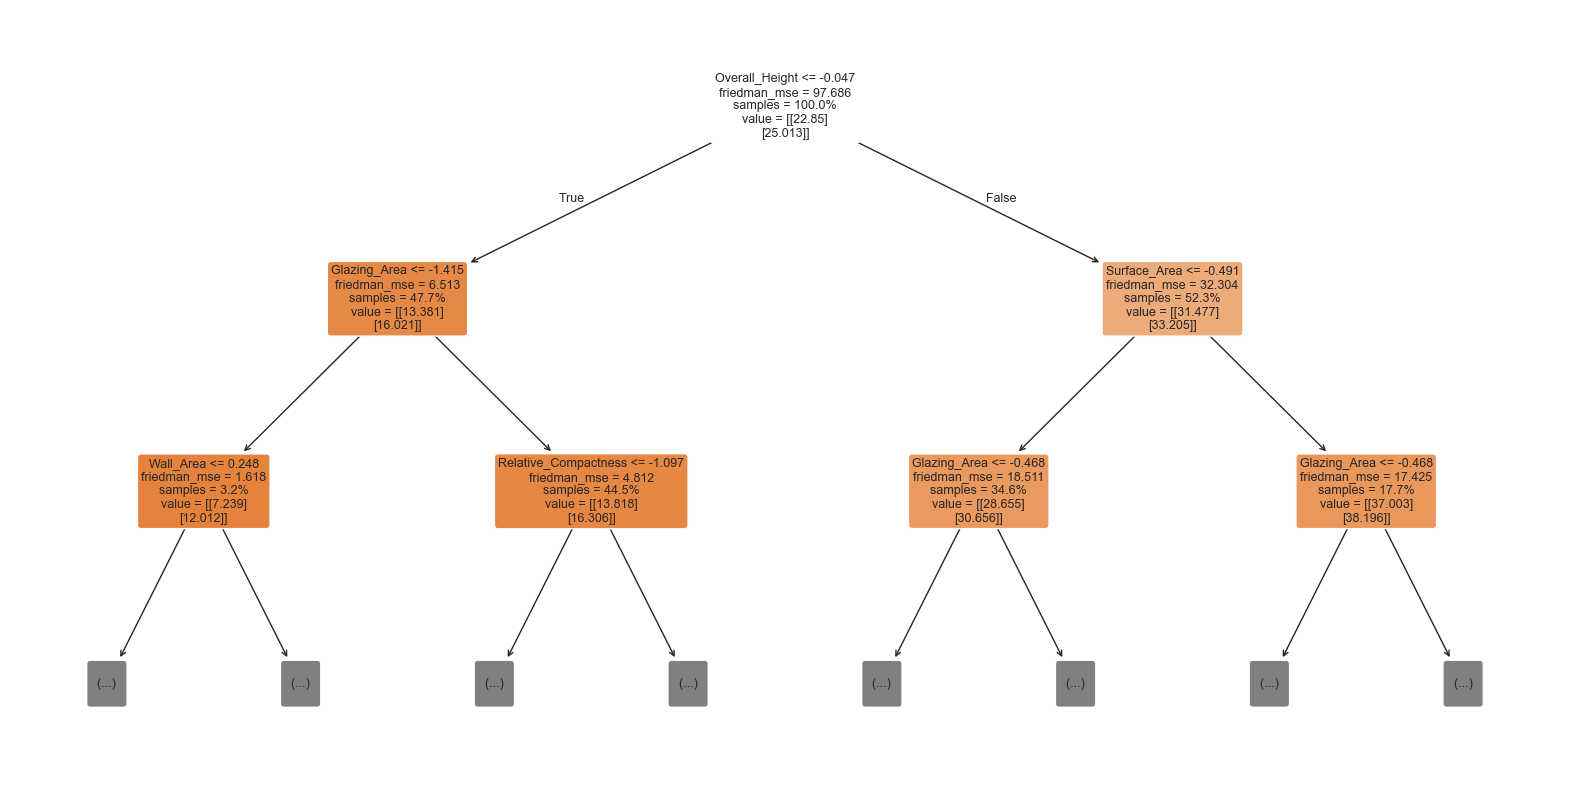

In [38]:
final_predictor = training_decisiontree_results["original"]["model"]

plt.figure(figsize=(20, 10))
plot_tree(
    final_predictor,
    feature_names=data["train"]["features"]["original"].columns,
    filled=True,
    rounded=True,
    proportion=True,
    max_depth=2, # Set up the max depth for better visualization
)
plt.show()


# Predictions vs Actual values on test set

In [39]:
actual_values_df = data["test"]["targets"]
predicted_values_df = pd.DataFrame(
    data=final_predictor.predict(data["test"]["features"]["original"]),
    columns=final_predictor.y_train.columns,
)


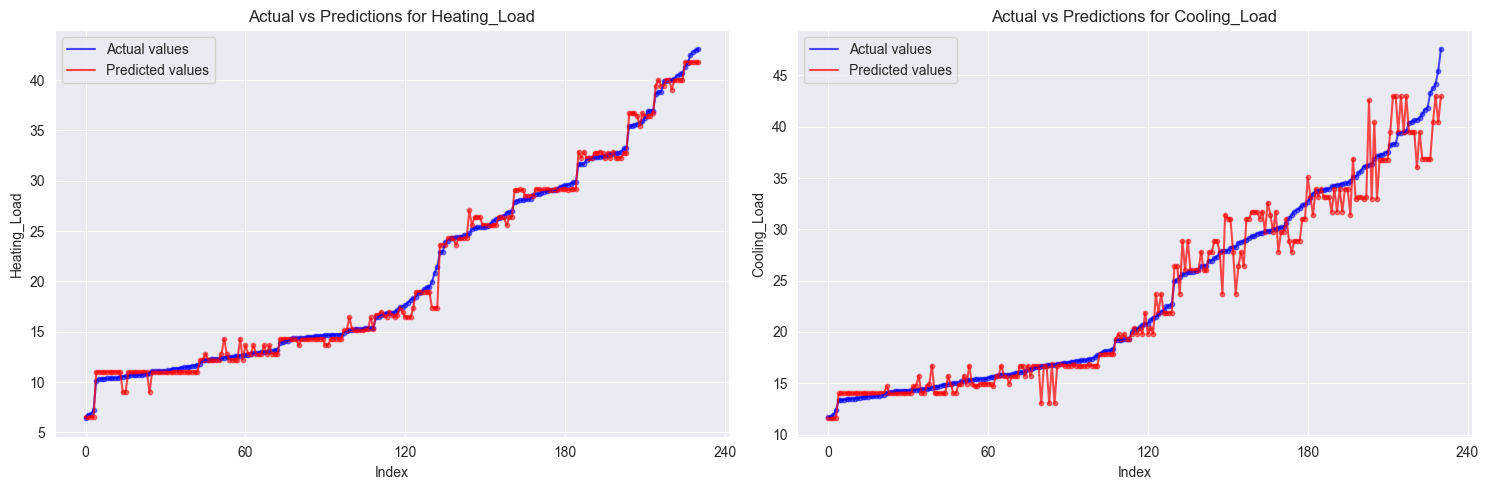

In [40]:
n_targets = len(final_predictor.y_train.columns)
n_rows = (n_targets + 1) // 2
n_cols = 2 if n_targets > 1 else 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), squeeze=False)

for x, target in enumerate(final_predictor.y_train.columns):
    row = x // 2
    col = x % 2

    ax = axes[row, col]

    combined_df = pd.DataFrame({
        'actual': actual_values_df[target].reset_index(drop=True),
        'predicted': predicted_values_df[target].reset_index(drop=True),
    })
    sorted_combined_df = combined_df.sort_values(by='actual').reset_index(drop=True)

    ax.plot(sorted_combined_df.index, sorted_combined_df['actual'], "b-", label="Actual values", alpha=0.7)
    ax.scatter(sorted_combined_df.index, sorted_combined_df['actual'], color="blue", s=10, alpha=0.5)

    ax.plot(sorted_combined_df.index, sorted_combined_df['predicted'], "r-", label="Predicted values", alpha=0.7)
    ax.scatter(sorted_combined_df.index, sorted_combined_df['predicted'], color="red", s=10, alpha=0.5)

    ax.set_title(f"Actual vs Predictions for {target}")
    ax.set_xlabel("Index")
    ax.set_ylabel(target)
    ax.legend()

    ax.xaxis.set_major_locator(plt.MaxNLocator(5))

if n_targets % 2 != 0 and n_targets > 1:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()


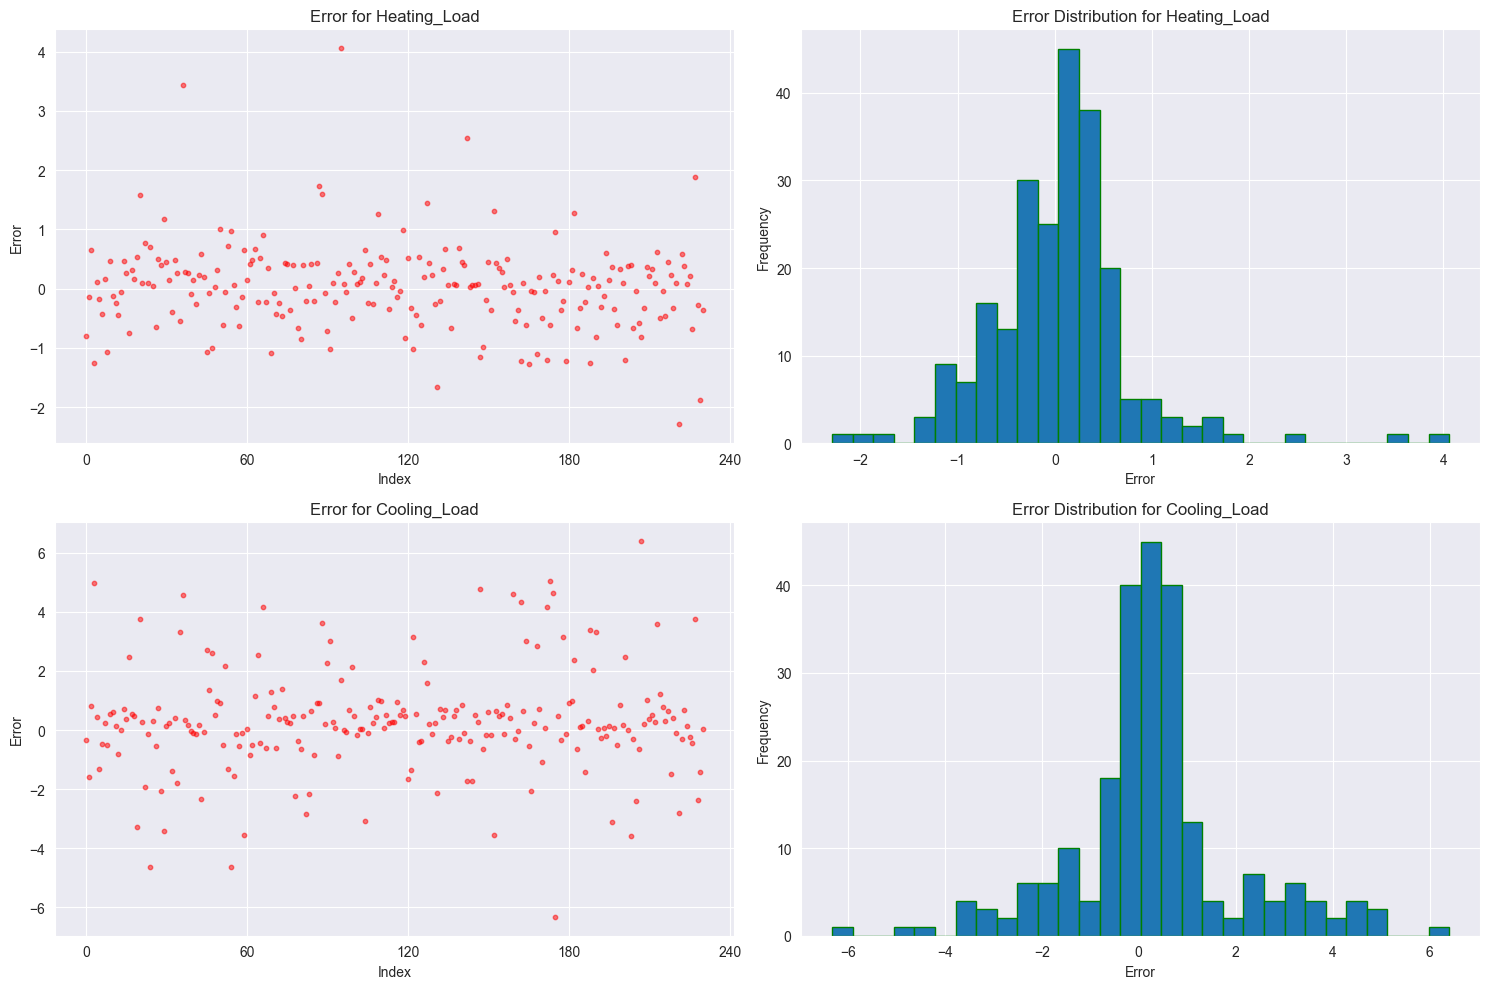

In [41]:
n_targets = len(final_predictor.y_train.columns)
n_rows = n_targets
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), squeeze=False)
fig.tight_layout(pad=3.0)

for x, target in enumerate(final_predictor.y_train.columns):

    ax_error = axes[x, 0]
    actual_df = actual_values_df[target].reset_index(drop=True)
    predicted_df = predicted_values_df[target].reset_index(drop=True)
    error_df = actual_df - predicted_df
    ax_error.scatter(predicted_df.index, error_df.values, color="red", s=10, alpha=0.5)

    ax_error.set_title(f"Error for {target}")
    ax_error.set_xlabel("Index")
    ax_error.set_ylabel("Error")
    ax_error.xaxis.set_major_locator(plt.MaxNLocator(5))

    ax_hist = axes[x, 1]
    ax_hist.hist(error_df.values, bins=30, edgecolor="green")
    ax_hist.set_title(f"Error Distribution for {target}")
    ax_hist.set_xlabel("Error")
    ax_hist.set_ylabel("Frequency")

plt.tight_layout()
plt.show()


For both targets, errors seem to be clustered around zero.

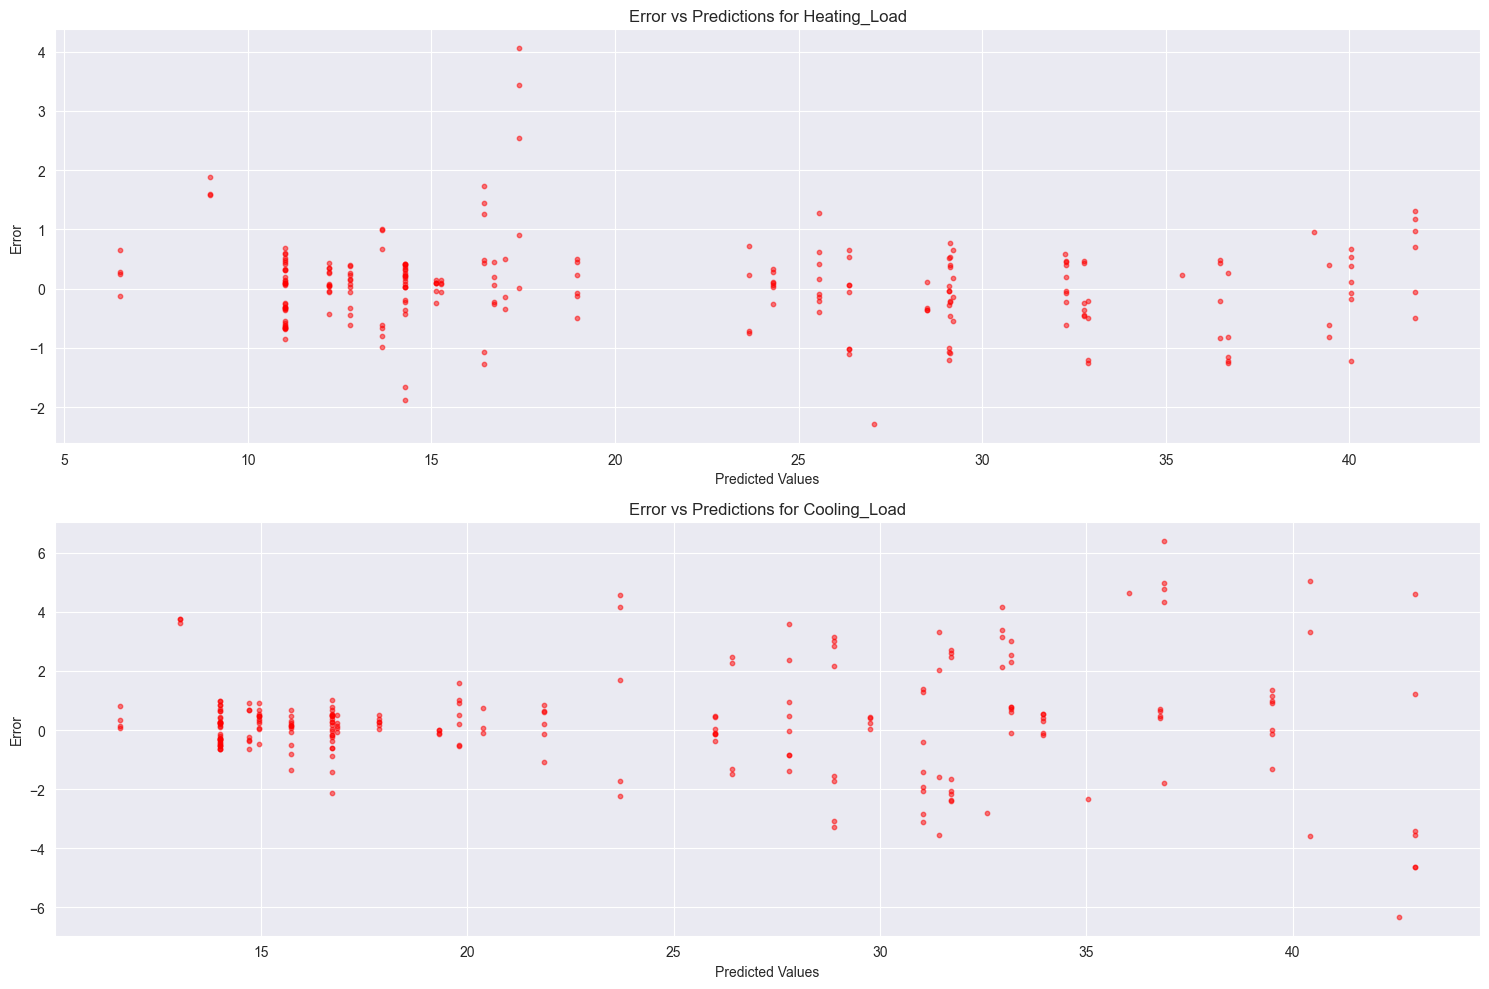

In [42]:
n_targets = len(final_predictor.y_train.columns)
n_rows = n_targets
n_cols = 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), squeeze=False)
fig.tight_layout(pad=3.0)

for x, target in enumerate(final_predictor.y_train.columns):

    ax_error = axes[x, 0]
    actual_df = actual_values_df[target].reset_index(drop=True)
    predicted_df = predicted_values_df[target].reset_index(drop=True)
    error_df = actual_df - predicted_df

    ax_error.scatter(predicted_df.values, error_df.values, color="red", s=10, alpha=0.5)

    ax_error.set_title(f"Error vs Predictions for {target}")
    ax_error.set_xlabel("Predicted Values")
    ax_error.set_ylabel("Error")

plt.tight_layout()
plt.show()


For both targets' predictions, no relationship seem to exist between them and their corresponding error values.

In [43]:
gc.collect()


7982